<a href="https://colab.research.google.com/github/techrhea777/Energy-Projects/blob/main/Borough_Level_Energy_Demand_Forecasting_and_Trend_Analysis_Using_OLS_Regression_and_Time_Series_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Borough-Level Energy Demand Forecasting and Trend Analysis Using OLS Regression and Time-Series Models

Code: Analyzing and Correlating Energy and Weather Data
Step 1: Load and Explore the LEGGI Dataset

Step 1: Load and Explore the LEGGI Dataset



In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
data = pd.read_csv('/content/energy-consumption-borough-leggi.csv')

# Inspect the dataset
print(data.head())
print(data.info())
print(data.describe())


                   Area  LEGGI_Year    Sector         Fuel Data_Year  \
0  Barking and Dagenham        2017  Domestic  Electricity      2017   
1                Barnet        2017  Domestic  Electricity      2017   
2                Bexley        2017  Domestic  Electricity      2017   
3                 Brent        2017  Domestic  Electricity      2017   
4               Bromley        2017  Domestic  Electricity      2017   

           kWh  
0  261584448.5  
1    618659527  
2  371815290.2  
3  424582525.8  
4  547354739.7  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5320 entries, 0 to 5319
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Area        5320 non-null   object
 1   LEGGI_Year  5320 non-null   int64 
 2   Sector      5320 non-null   object
 3   Fuel        5320 non-null   object
 4   Data_Year   4200 non-null   object
 5   kWh         5318 non-null   object
dtypes: int64(1), object(5)
memory usag

Step 2: Exploratory Data Analysis (EDA)


Visualize Energy Consumption by Sector and Fuel



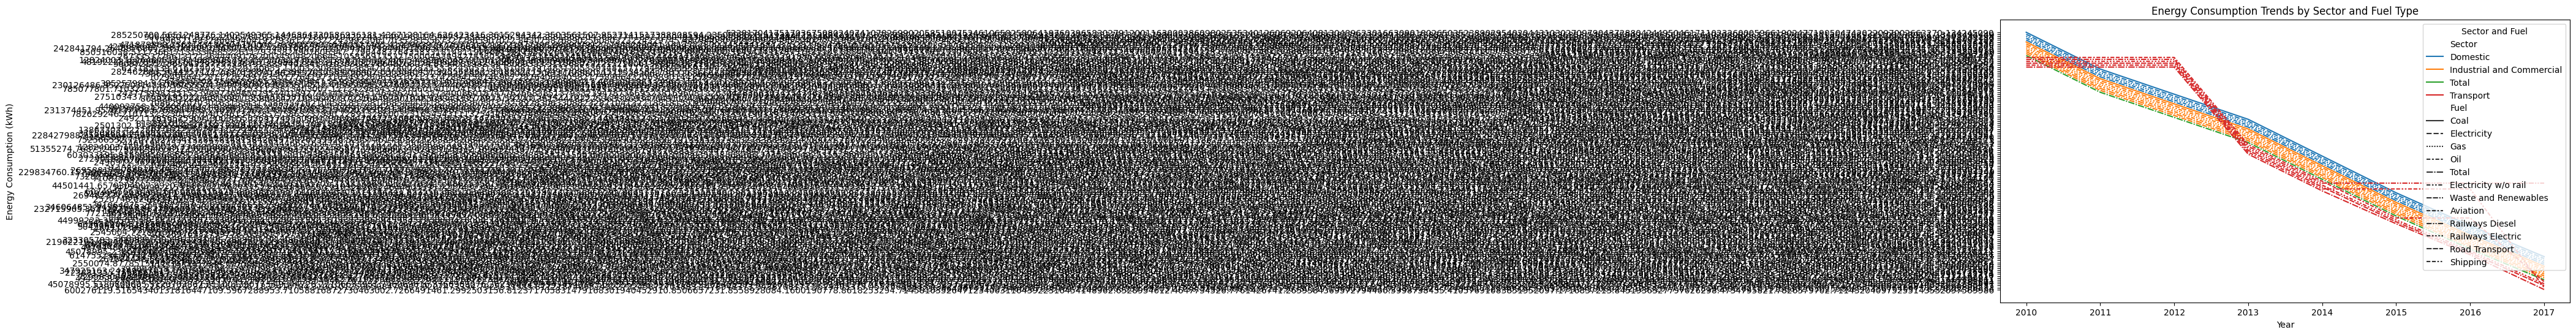

In [19]:
# Group by year, sector, and fuel
grouped_data = data.groupby(['LEGGI_Year', 'Sector', 'Fuel'])['kWh'].sum().reset_index()

# Plot energy consumption trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_data, x='LEGGI_Year', y='kWh', hue='Sector', style='Fuel')
plt.title('Energy Consumption Trends by Sector and Fuel Type')
plt.xlabel('Year')
plt.ylabel('Energy Consumption (kWh)')
plt.legend(title='Sector and Fuel')
plt.show()


In [21]:
# Aggregate data by Area and Sector
pivot_energy = data.groupby(['Area', 'Sector'])['kWh'].sum().reset_index()
pivot_energy = pivot_energy.pivot(index='Area', columns='Sector', values='kWh').fillna(0)




In [23]:
# Convert 'kWh' column to numeric
data['kWh'] = pd.to_numeric(data['kWh'], errors='coerce')

# Check for missing or invalid values
print(data['kWh'].isnull().sum())  # Number of invalid values converted to NaN


114


In [24]:
# Define a threshold (e.g., 99th percentile) to remove extreme outliers
threshold = data['kWh'].quantile(0.99)  # Top 1% values
data_filtered = data[data['kWh'] <= threshold]

# Check the new range of values
print(data_filtered['kWh'].describe())


count    5.153000e+03
mean     7.985307e+08
std      1.812042e+09
min     -5.255144e+07
25%      6.165869e+06
50%      2.917690e+08
75%      9.621452e+08
max      2.566080e+10
Name: kWh, dtype: float64


In [25]:
# Scale down 'kWh' values to MWh for readability
data['kWh_scaled'] = data['kWh'] / 1e6


In [26]:
import numpy as np

# Apply log transformation (add a small constant to avoid log(0))
data['kWh_log'] = np.log1p(data['kWh'])


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Heatmap of Energy Consumption by Area and Sector


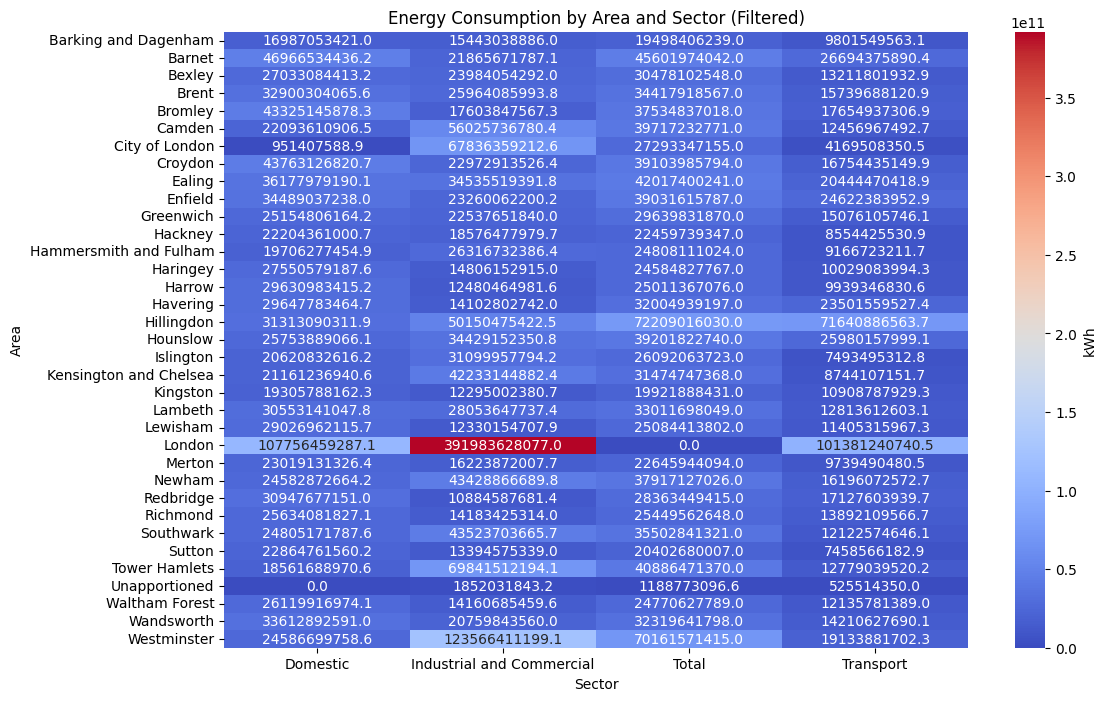

In [27]:
# Group by Area and Sector with filtered data
area_sector_energy = data_filtered.groupby(['Area', 'Sector'])['kWh'].sum().reset_index()

# Pivot the table
pivot_energy = area_sector_energy.pivot(index='Area', columns='Sector', values='kWh').fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_energy, annot=True, fmt=".1f", cmap='coolwarm', cbar_kws={'label': 'kWh'})
plt.title('Energy Consumption by Area and Sector (Filtered)')
plt.xlabel('Sector')
plt.ylabel('Area')
plt.show()


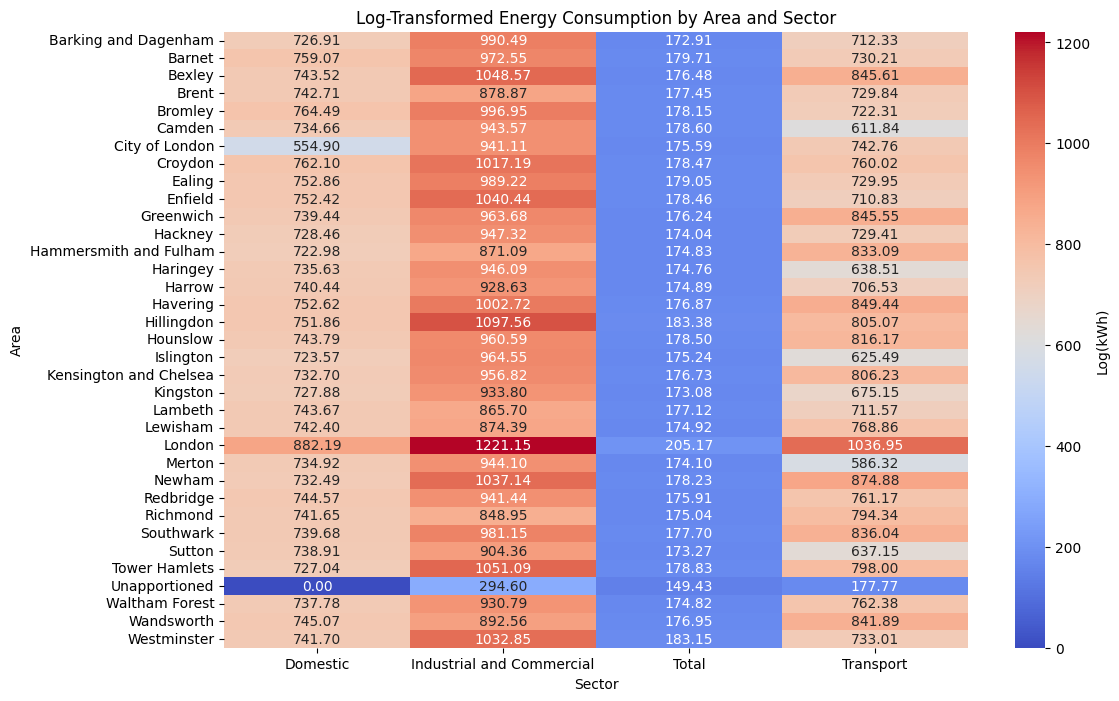

In [28]:
# Group by Area and Sector with log-transformed data
area_sector_energy_log = data.groupby(['Area', 'Sector'])['kWh_log'].sum().reset_index()

# Pivot the table
pivot_energy_log = area_sector_energy_log.pivot(index='Area', columns='Sector', values='kWh_log').fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_energy_log, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Log(kWh)'})
plt.title('Log-Transformed Energy Consumption by Area and Sector')
plt.xlabel('Sector')
plt.ylabel('Area')
plt.show()


Step 3: OLS Regression
Prepare the Data for Regression

In [29]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode categorical variables
encoded_data = pd.get_dummies(data, columns=['Sector', 'Fuel'], drop_first=True)

# Define dependent and independent variables
X = encoded_data[['LEGGI_Year'] + [col for col in encoded_data if col.startswith('Sector_') or col.startswith('Fuel_')]]
y = encoded_data['kWh']

# Add constant for OLS
X = sm.add_constant(X)


In [31]:
# Check the data types of X and y
print(X.dtypes)
print(y.dtypes)


const                               float64
LEGGI_Year                            int64
Sector_Industrial and Commercial       bool
Sector_Total                           bool
Sector_Transport                       bool
Fuel_Coal                              bool
Fuel_Electricity                       bool
Fuel_Electricity w/o rail              bool
Fuel_Gas                               bool
Fuel_Oil                               bool
Fuel_Railways Diesel                   bool
Fuel_Railways Electric                 bool
Fuel_Road Transport                    bool
Fuel_Shipping                          bool
Fuel_Total                             bool
Fuel_Waste and Renewables              bool
dtype: object
float64


In [32]:
# Convert all boolean columns in X to float
X = X.astype(float)

# Confirm the data types are now float64
print(X.dtypes)


const                               float64
LEGGI_Year                          float64
Sector_Industrial and Commercial    float64
Sector_Total                        float64
Sector_Transport                    float64
Fuel_Coal                           float64
Fuel_Electricity                    float64
Fuel_Electricity w/o rail           float64
Fuel_Gas                            float64
Fuel_Oil                            float64
Fuel_Railways Diesel                float64
Fuel_Railways Electric              float64
Fuel_Road Transport                 float64
Fuel_Shipping                       float64
Fuel_Total                          float64
Fuel_Waste and Renewables           float64
dtype: object


In [33]:
# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Display the regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    kWh   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 16 Nov 2024   Prob (F-statistic):                nan
Time:                        19:03:54   Log-Likelihood:                    nan
No. Observations:                5320   AIC:                               nan
Df Residuals:                    5304   BIC:                               nan
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [34]:
print(y.dtypes)


float64


In [35]:
X = X.dropna()
y = y.dropna()


In [36]:
X, y = X.align(y, join='inner', axis=0)


Fit OLS Regression Model

In [37]:
# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Display the regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    kWh   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     27.85
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           2.29e-76
Time:                        19:05:03   Log-Likelihood:            -1.2503e+05
No. Observations:                5206   AIC:                         2.501e+05
Df Residuals:                    5190   BIC:                         2.502e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [39]:
# Check for missing values in filtered_data
print(filtered_data.isnull().sum())

# Drop missing values or fill them with appropriate values (e.g., 0 or forward-fill)
filtered_data = filtered_data.dropna()
# Alternatively, you can fill missing values:
# filtered_data = filtered_data.fillna(method='ffill')

# Ensure the time series index is continuous
filtered_data = filtered_data.sort_index()  # Sort by year (index)
print(filtered_data)


0
LEGGI_Year
2010    3.473633e+09
2011    3.012898e+09
2012    3.175087e+09
2013    3.207560e+09
2014    2.965345e+09
2015    2.843738e+09
2016    2.918227e+09
2017    2.990209e+09
Name: kWh, dtype: float64


In [40]:
# Create a continuous range of years
full_index = pd.RangeIndex(start=filtered_data.index.min(), stop=filtered_data.index.max() + 1)

# Reindex the time series to ensure continuous years
filtered_data = filtered_data.reindex(full_index, fill_value=0)  # Fill missing years with 0 or other values

# Check the reindexed time series
print(filtered_data)


2010    3.473633e+09
2011    3.012898e+09
2012    3.175087e+09
2013    3.207560e+09
2014    2.965345e+09
2015    2.843738e+09
2016    2.918227e+09
2017    2.990209e+09
Name: kWh, dtype: float64


In [42]:
import pandas as pd

# Ensure filtered_data is a Pandas Series
filtered_data = pd.Series(filtered_data)

# Check for missing values and drop if necessary
filtered_data = filtered_data.dropna()

# Ensure filtered_data is numeric
print(filtered_data.dtypes)  # Should be float64


float64


Autocorrelation Analysis of Energy Consumption


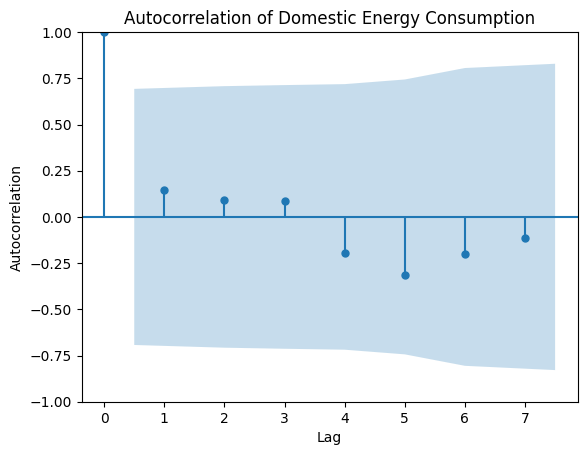

In [53]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Plot autocorrelation with adjusted lags
plot_acf(filtered_data, lags=7)
plt.title('Autocorrelation of Domestic Energy Consumption')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()



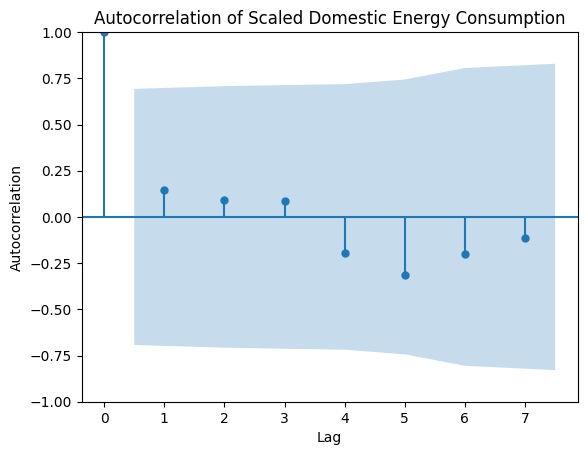

In [44]:
# Normalize the data by dividing by 1e9
filtered_data_scaled = filtered_data / 1e9

# Plot autocorrelation with scaled data
plot_acf(filtered_data_scaled, lags=7)
plt.title('Autocorrelation of Scaled Domestic Energy Consumption')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()


Step 5: Forecast Energy Demand
1. Prepare Time-Series Data

In [46]:
# Create time series for Westminster Domestic energy
time_series = filtered_data


2. Fit ARIMA Model

In [47]:
# Fit ARIMA model
model = ARIMA(time_series, order=(1, 1, 1))  # Adjust order (p, d, q) as needed
fitted_model = model.fit()

# Forecast for next 5 years
forecast = fitted_model.forecast(steps=5)
print(f"Forecasted Energy Consumption: {forecast}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

Forecasted Energy Consumption: 8     2.982046e+09
9     2.983992e+09
10    2.983528e+09
11    2.983639e+09
12    2.983612e+09
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


3. Plot Forecast Results

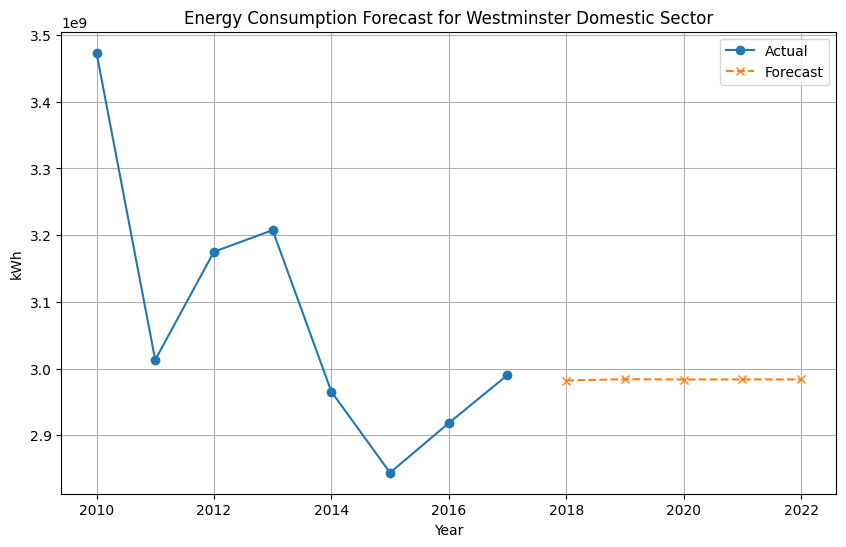

In [49]:
# Get the last year from the actual data
last_year = time_series.index[-1]

# Create forecast years
forecast_years = range(last_year + 1, last_year + 6)  # Next 5 years

# Plot actual and forecasted energy consumption
plt.figure(figsize=(10, 6))
plt.plot(time_series.index, time_series, label='Actual', marker='o')  # Use actual years for the x-axis
plt.plot(forecast_years, forecast, label='Forecast', linestyle='--', marker='x')
plt.title('Energy Consumption Forecast for Westminster Domestic Sector')
plt.xlabel('Year')
plt.ylabel('kWh')
plt.legend()
plt.grid()
plt.show()


In [50]:
print(time_series.index)


Index([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], dtype='int64', name='LEGGI_Year')


In [51]:
time_series.index = time_series.index.astype(int)


3. Plot Forecast Results

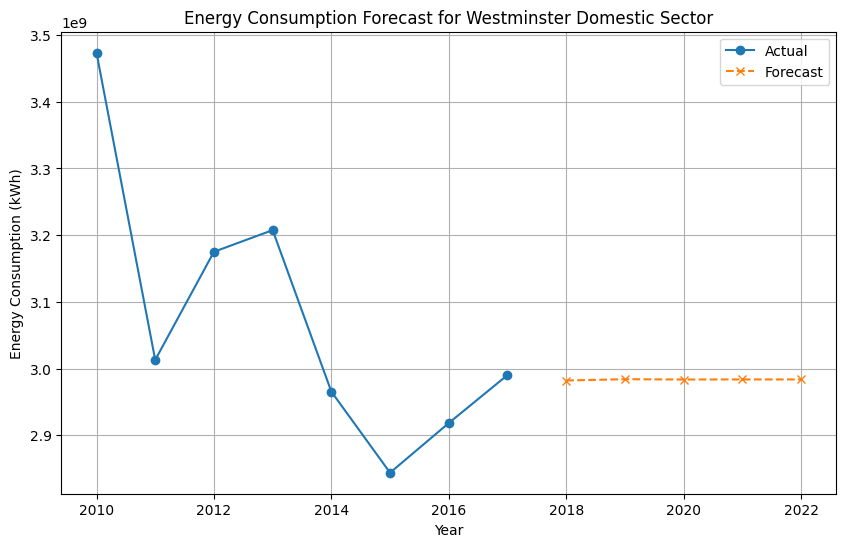

In [52]:
import matplotlib.pyplot as plt

# Ensure time_series has numeric years as the index
time_series.index = time_series.index.astype(int)

# Get the last year from the actual data
last_year = time_series.index[-1]

# Create forecast years
forecast_years = range(last_year + 1, last_year + 6)  # Next 5 years

# Plot actual and forecasted energy consumption
plt.figure(figsize=(10, 6))
plt.plot(time_series.index, time_series, label='Actual', marker='o')  # Actual data
plt.plot(forecast_years, forecast, label='Forecast', linestyle='--', marker='x')  # Forecast data
plt.title('Energy Consumption Forecast for Westminster Domestic Sector')
plt.xlabel('Year')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.show()
